In [2]:
import datasets
import os
import openai

/Users/federico.cassano/.pyenv/versions/3.9.19/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Full Dataset (OG)

In [ ]:
client = openai.Client(api_key=os.environ["OPENAI_API_KEY"])

In [3]:
ds = datasets.load_from_disk("../dataset/on_disk/orm_dataset_raw50_og/")
ds

Dataset({
    features: ['unique_name', 'prompt', 'starter_code', 'difficulty', 'results'],
    num_rows: 13402
})

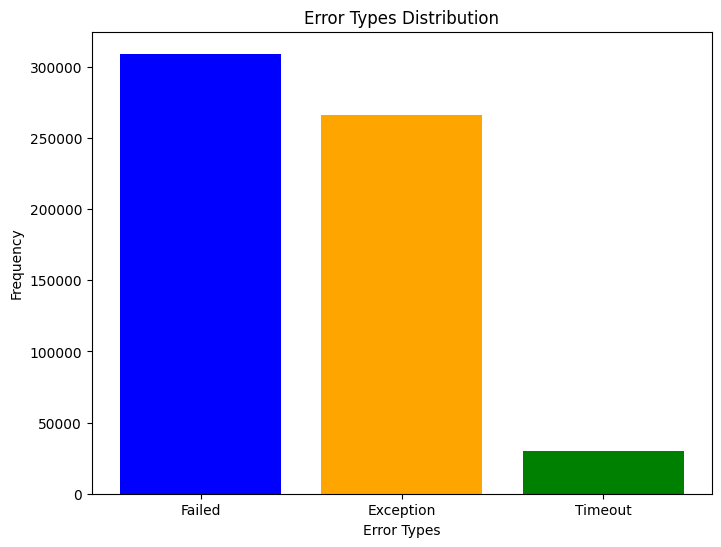

In [7]:
import matplotlib.pyplot as plt
from coderm.eval.redo_code_execution import get_err_kind
    
errs = [] # err types: "Timeout", "Exception", "Failed Tests"
timeout_exs = []
at_least_one_passing = []
for ex in ds:
    passing = None
    for r in ex["results"]:
        if not r["passing"]:
            kind = get_err_kind(r)
            errs.append(kind)
            if kind == "Timeout":
                timeout_exs.append((ex, r["code"], r["output"]))
        else:
            passing = r["code"]
        
    if passing != None:
        at_least_one_passing.append(ex)

error_counts = {error: errs.count(error) for error in set(errs)}

error_types = list(error_counts.keys())
counts = list(error_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(error_types, counts, color=['blue', 'orange', 'green'])
plt.xlabel('Error Types')
plt.ylabel('Frequency')
plt.title('Error Types Distribution')
plt.show()

/var/folders/fv/sclrswvx1c58rgf9y06976x40000gp/T/ipykernel_6973/2652822155.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)


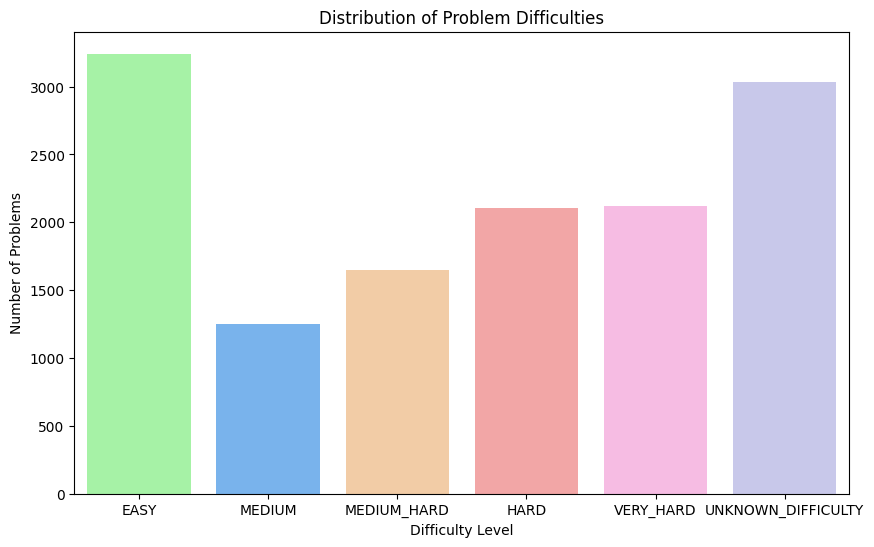

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = ds.to_pandas()

difficulty_counts = df['difficulty'].value_counts()

order = ['EASY', 'MEDIUM', 'MEDIUM_HARD', 'HARD', 'VERY_HARD', 'UNKNOWN_DIFFICULTY']

ordered_difficulty_counts = pd.Series([difficulty_counts.get(level, 0) for level in order], index=order)

colors = ['#99ff99', '#66b3ff', '#ffcc99', '#ff9999', '#ffb3e6', '#c2c2f0']

plt.figure(figsize=(10, 6))
sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)
plt.title('Distribution of Problem Difficulties')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Problems')
plt.show()

/var/folders/fv/sclrswvx1c58rgf9y06976x40000gp/T/ipykernel_6973/1802992831.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)


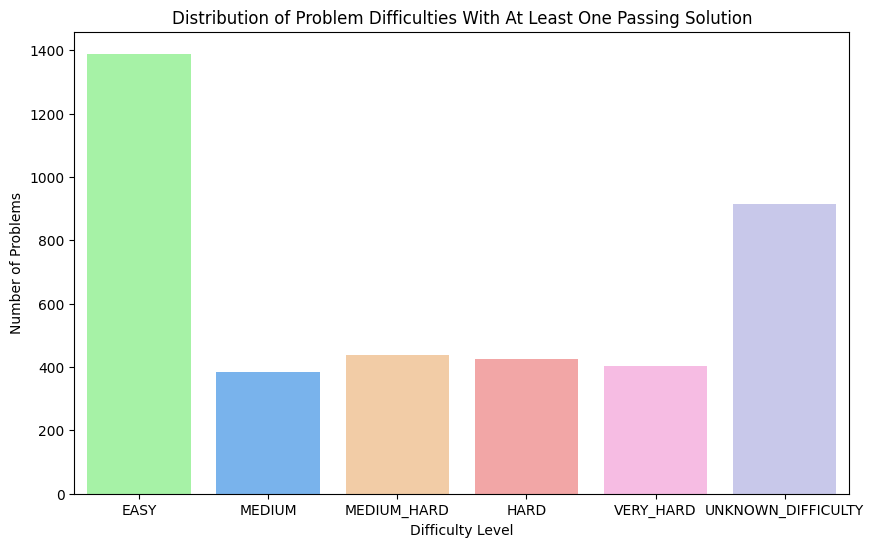

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pds = datasets.Dataset.from_list(at_least_one_passing)
df = pds.to_pandas()

difficulty_counts = df['difficulty'].value_counts()

order = ['EASY', 'MEDIUM', 'MEDIUM_HARD', 'HARD', 'VERY_HARD', 'UNKNOWN_DIFFICULTY']

ordered_difficulty_counts = pd.Series([difficulty_counts.get(level, 0) for level in order], index=order)

colors = ['#99ff99', '#66b3ff', '#ffcc99', '#ff9999', '#ffb3e6', '#c2c2f0']

plt.figure(figsize=(10, 6))
sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)
plt.title('Distribution of Problem Difficulties With At Least One Passing Solution')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Problems')
plt.show()

# GPT-4 agreement

In [ ]:
from coderm.prompts import py_prompt
import random
random.seed(42)
check_size = 5000
samples = []
for ex in ds.select(range(check_size)):
    r = random.choice(ex["results"])
    code = r["code"]
    code = ex["starter_code"] + code
    code = py_prompt(ex["prompt"], code)
    r["code"] = code
    samples.append(r)
print(samples[100]["code"])

In [62]:
from tqdm import tqdm
code = samples[0]["code"]
def gpt_classifier(code, model="gpt-4o"):
    system = "You are a champion competitive programmer. You are able to identify if an algorithmic solution to a problem is either correct or not. You will respond only with Yes or No, then, only after the Yes/No, you will provide a very brief explaination of why."
    resp = client.chat.completions.create(
        model=model,
        temperature=0.0,
        messages=[
            {
                "role": "system",
                "content": system,
            },
            {
                "role": "user",
                "content": f"Please respond with Yes or No if the given program is correct or not, then after the newline, very briefly explain why:\n{code}",
            }
        ]
    )
    split = resp.choices[0].message.content.split("\n")
    if len(split) < 2:
        return None
    split = [s for s in split if s.strip() != ""]
    cls = split[0].strip()
    exp = "\n".join(split[1:])
    if cls != "Yes" and cls != "No":
        return None
    if cls == "Yes":
        cls_b = True
    elif cls == "No":
        cls_b = False
    return cls_b, exp

new_ds = datasets.Dataset.from_list(samples)
cls = [None] * len(samples)
exp = [None] * len(samples)
new_ds = new_ds.add_column("cls", cls)
new_ds = new_ds.add_column("exp", exp)

def run_cls(ex):
    code = ex["code"]
    out = gpt_classifier(code)
    if out is not None:
        cls, exp = out
        return {"cls": cls, "exp": exp}

new_ds = new_ds.map(run_cls, num_proc=96)

Map (num_proc=96): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:39<00:00, 50.06 examples/s]


In [64]:
bad_cls = 0
agreement = 0
disagrees_on_passing = 0
disagrees_on_failing = 0
disagrees = []
for ex in new_ds:
    cls = ex["cls"]
    p = ex["passing"]
    
    if cls is None:
        bad_cls += 1
        continue
        
    if cls == p:
        agreement += 1
    else:
        if p:
            disagrees_on_passing += 1
        else:
            disagrees_on_failing += 1
        disagrees.append(ex)

print(f"Agreement rate: {agreement / len(new_ds)}")
print(f"Disagrees on tests passing: {disagrees_on_passing / len(disagrees)}")
print(f"Disagrees on tests failing: {disagrees_on_failing / len(disagrees)}")

Agreement rate: 0.9066
Disagrees on tests passing: 0.7387580299785867
Disagrees on tests failing: 0.26124197002141325


# Timeout analysis

In [52]:
import datasets
ds = datasets.load_dataset("codegenning/orm_dataset_raw50", split="train")
ds

Dataset({
    features: ['content', 'score', 'solution', 'output', 'question', 'starter_code'],
    num_rows: 76338
})

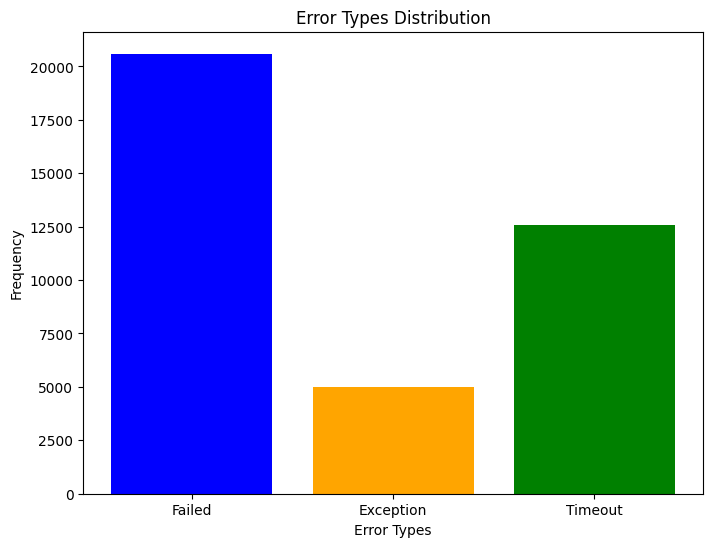

In [60]:
import matplotlib.pyplot as plt
from coderm.eval.redo_code_execution import get_err_kind
    
errs = [] # err types: "Timeout", "Exception", "Failed Tests"
timeout_exs = []
for ex in ds:
    if not ex["score"]:
        kind = get_err_kind(ex)
        errs.append(kind)
        if kind == "Timeout":
            timeout_exs.append((ex, ex["content"], ex["output"]))

error_counts = {error: errs.count(error) for error in set(errs)}

error_types = list(error_counts.keys())
counts = list(error_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(error_types, counts, color=['blue', 'orange', 'green'])
plt.xlabel('Error Types')
plt.ylabel('Frequency')
plt.title('Error Types Distribution')
plt.show()

In [67]:
import datasets
orig_ds = datasets.load_dataset("cassanof/taco_cleaned_all", split="train")
orig_ds

Dataset({
    features: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity'],
    num_rows: 13402
})

In [61]:
print(len(timeout_exs))

12561


In [66]:
import json
from coderm.execution import smart_exec_tests_queuebatched
i = 55
ex, code, o = timeout_exs[i]
q = ex["question"]
orig_ex = orig_ds.filter(lambda ex: ex["question"] == q)[0]
tests = json.loads(orig_ex["input_output"])
limit = orig_ex["time_limit"]
print(f"Time Limit: {limit}")
print(f"Output: {o}")
# print(tests)
print(code)
smart_exec_tests_queuebatched([code], [tests])

Filter: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13402/13402 [00:01<00:00, 6857.11 examples/s]


Time Limit: 1 second
Output: errored with 'Timeout'

"""
Koa the Koala and her best friend want to play a game.

The game starts with an array $a$ of length $n$ consisting of non-negative integers. Koa and her best friend move in turns and each have initially a score equal to $0$. Koa starts.

Let's describe a move in the game:  During his move, a player chooses any element of the array and removes it from this array, xor-ing it with the current score of the player.

 More formally: if the current score of the player is $x$ and the chosen element is $y$, his new score will be $x \oplus y$. Here $\oplus$ denotes bitwise XOR operation.

 Note that after a move element $y$ is removed from $a$.

  The game ends when the array is empty. 

At the end of the game the winner is the player with the maximum score. If both players have the same score then it's a draw.

If both players play optimally find out whether Koa will win, lose or draw the game.


-----Input-----

Each test contains multip

Executing tests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


[(False,
  "[1] expected 'WIN\\nWIN\\nDRAW\\nWIN\\n' but got '\\nLOSE\\nLOSE\\nDRAW\\nLOSE\\n'\n")]